# A/B Testing
by Kuanchieh Peng

## Problem Statement
The goal is to verify an existing conversion hypthesis with A/B tests and regression analysis.
## Brief
 - Calculate for p-value for A/B testing
 - Conduct Z-tests for A/B testing
 - Regression analysis
 - Multivariate regression

## Imports

In [113]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

In [114]:
df = pd.read_csv('conversion.csv')

## Data Assessment

In [115]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0


In [116]:
df.shape

(116504, 5)

In [117]:
df = df.dropna(subset = ['user_id', 'timestamp', 'group', 'landing_page'])
df = df.fillna(0)

In [118]:
control_converted = df[(df.group == "control") & (df.converted == 1)].shape[0] / df[df.group == "control"].shape[0]

exp_converted = df[(df.group == "treatment") & (df.converted == 1)].shape[0] / df[df.group == "treatment"].shape[0]

In [119]:
print("Control conversion %: ", control_converted * 100)
print("Experiment conversion %: ", exp_converted * 100)

Control conversion %:  11.993806984345433
Experiment conversion %:  11.880492693539821


The experiment's conversion rate is 0.11% lower than the control's.

## A/B Testing with p-value

Null Hypothesis: P𝑜𝑙𝑑 - P𝑛𝑒𝑤 = 0

Alternative:     P𝑜𝑙𝑑 - P𝑛𝑒𝑤 != 0
> 1. Find the observed difference
> 2. Boostrap the sampling distribution to get the standard deviation
> 3. Simulate the distribution centered under the null hypothesis
> 4. Calculate for the p-value
> 5. Determine the statistical significance of our observed difference

**Finding observed difference**

In [120]:
observed_diff = control_converted - exp_converted
observed_diff

0.00113314290805612

**Boostrapping the sample to get standard deviation**

In [121]:
sample_diff = []

for i in range(10000):
    sample = df.sample(200, replace = True)
    control = sample.query('group == "control"')
    control_cvr = control.query("converted == 1").shape[0] / control.shape[0]
    exp = sample.query('group == "treatment"')
    exp_cvr = exp.query('converted == 1').shape[0] / exp.shape[0]
    sample_diff.append(control_cvr - exp_cvr)

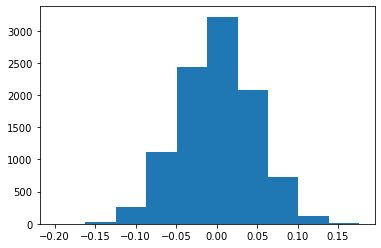

In [122]:
plt.hist(sample_diff)
plt.show()

In [123]:
std_sampling = np.std(sample_diff)
std_sampling

0.046051917115687235

**Simulate the distribution centered under the null hypothesis**

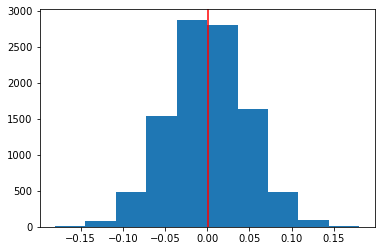

In [124]:
null_vals = np.random.normal(0, std_sampling, len(sample_diff))
plt.hist(null_vals);
plt.axvline(x = observed_diff, color = 'red');
plt.show()

## A/B Testing with Z-test

In [125]:
convert_old = df.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df.query('converted == 1 and landing_page == "new_page"').shape[0]
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

In [126]:
convert_old, convert_new, n_old, n_new

(6972, 6935, 58130, 58373)

In [127]:
count = np.array([convert_old,convert_new])
nobs = np.array([n_old, n_new])

stat, pval = proportions_ztest(count, nobs)
stat, pval

(0.5964547012657413, 0.5508715068597727)

The p value ~= 0.55, meaning we fail to reject the null hypothesis. We are confident that the control group and experiment group have similar results.

## Regression

Apply logsitic regression since it is appropriate for predicting binary results.

The goal is to use statsmodels to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we will have to first create a column for the intercept in df, and a dummy variable for the page each user received. Add an intercept column and an ab_page column, which yields 1 when a customer receives the treatment and 0 if else. 

In [128]:
df['intercept'] = 1
df[['control', 'treatment']] = pd.get_dummies(df['group'])

LR = sm.Logit(df['converted'], df[['intercept', 'treatment']])
 
results = LR.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.365667
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: converted        AIC:              85206.6013
Date:               2022-04-08 20:39 BIC:              85225.9326
No. Observations:   116503           Log-Likelihood:   -42601.   
Df Model:           1                LL-Null:          -42601.   
Df Residuals:       116501           LLR p-value:      0.55087   
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept   -1.9930    0.0128  -156.1156  0.0000  -2.0180  -1.9680
treatment   -0.0108    0.0181    -0.5965  0.5509  -0.0462   0.0246
=================================================================

"""

The p value associated with the treatment gorup ~= 0.55, meaning we fail to reject the null hypothesis.

## Multivariate regression analysis
Conduct multivariate regression analysis on whether the variable, country, affects conversion rates.

In [138]:
df2 = pd.read_csv('countries.csv')
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [139]:
df2 = df.join(df2.set_index('user_id'), on = 'user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0,1,1,0,US


In [140]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

LR = sm.Logit(df2['converted'], df2[['intercept', 'treatment', 'CA', 'UK']])

results = LR.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.365647
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.000     
Dependent Variable: converted        AIC:              85206.0500
Date:               2022-04-08 21:33 BIC:              85244.7127
No. Observations:   116503           Log-Likelihood:   -42599.   
Df Model:           3                LL-Null:          -42601.   
Df Residuals:       116499           LLR p-value:      0.17873   
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
intercept   -2.0043    0.0141  -142.1201  0.0000  -2.0319  -1.9767
treatment   -0.0108    0.0181    -0.5982  0.5497  -0.0462   0.0246
CA           0.0012    0.0421     0.0296  0.9764  -0.0812   0.0837
UK           0.0443    0.0209     2.1237  0.0337   0.0034   0.0853
=================================================================

"""

Discovery: the variable country did have statistical significance in affecting conversion rates, since the p value associated with UK ~= 0.03.